In [11]:
import scanpy as sc
import numpy as np
from scipy.stats import median_abs_deviation
import seaborn as sns
import matplotlib.pyplot as plt

# Path to your HDF5 file
file_path = '/Volumes/Jagannath/Projects/Single_Cell_Upstream/single_cell/Visium_Human_Breast_Cancer_raw_feature_bc_matrix.h5'

# Read the file
adata = sc.read_10x_h5(file_path)

adata.var_names_make_unique()

print("AnnData object:")
print(adata)  # Print summary (n_obs x n_vars)


AnnData object:
AnnData object with n_obs × n_vars = 4992 × 36601
    var: 'gene_ids', 'feature_types', 'genome'


/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Gene Annotation Overview:
Mitochondrial Genes (mt):
Number of mitochondrial genes identified: 13
These genes usually indicate mitochondrial activity, and high expression of these genes may signal stressed or dying cells. These are flagged as True in the mt column.

Ribosomal Genes (ribo):
Number of ribosomal genes identified: 103
Ribosomal protein genes are often highly expressed in rapidly dividing cells and may dominate the transcriptome. These are flagged as True in the ribo column.

Hemoglobin Genes (hb):
Number of hemoglobin genes identified: 12
Hemoglobin genes are usually specific to blood or blood-related datasets. Overrepresentation of these genes could indicate contamination with blood cells. These are flagged as True in the hb column.

In [12]:
# 3. Annotate Gene Types
# --------------------------
# For human data, mitochondrial genes usually start with 'MT-'
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# Ribosomal genes typically start with 'RPS' or 'RPL'
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# Hemoglobin genes can be identified with a regex pattern
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))


# Check the first few rows of adata.var to confirm changes
print(adata.var.head())

# Check how many genes fall under each annotation
print("Mitochondrial genes:", adata.var["mt"].sum())
print("Ribosomal genes:", adata.var["ribo"].sum())
print("Hemoglobin genes:", adata.var["hb"].sum())


                    gene_ids    feature_types  genome     mt   ribo     hb
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False  False  False
FAM138A      ENSG00000237613  Gene Expression  GRCh38  False  False  False
OR4F5        ENSG00000186092  Gene Expression  GRCh38  False  False  False
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  False  False  False
AL627309.3   ENSG00000239945  Gene Expression  GRCh38  False  False  False
Mitochondrial genes: 13
Ribosomal genes: 103
Hemoglobin genes: 12


### Interpret the results
Mitochondrial Genes: 13
There are 13 mitochondrial genes in the dataset. You can use this information for quality control by checking the percentage of mitochondrial gene expression in each cell.

Ribosomal Genes: 103
There are 103 ribosomal genes. This count is typical for most datasets and reflects the presence of housekeeping genes.

Hemoglobin Genes: 12
There are 12 hemoglobin genes. If these are not relevant to your experiment, you may need to exclude them or remove cells where hemoglobin expression dominates.

Why Do We Calculate QC Metrics?
Quality control (QC) is a critical step in single-cell RNA-seq analysis to ensure that only high-quality cells are retained for downstream analyses. By calculating per-cell QC metrics, we can:

Identify low-quality cells: Cells with abnormal properties, such as very high mitochondrial gene expression or low gene counts, are flagged.

Assess the dataset: Understand the variability in the dataset before applying filtering criteria.

Detect technical artifacts: Certain metrics, like hemoglobin or ribosomal gene expression, can indicate contamination or over-representation.

Key Parameters:

qc_vars: Specifies gene categories (e.g., mt, ribo, hb) to compute QC metrics for. Metrics such as the percentage of counts attributed to these gene categories are calculated.
percent_top=[20]: Calculates the percentage of total counts from the top 20 most highly expressed genes for each cell. This indicates whether certain genes dominate the transcriptome.
log1p=True: Applies a natural logarithmic transformation to the counts (log(1+x)) to stabilize variance before computing metrics.

Important Metrics:

n_genes_by_counts:
Number of genes with non-zero counts for each cell.
Interpretation: Low values may indicate damaged or low-quality cells.

pct_counts_mt (not shown but calculated internally):
Percentage of total counts derived from mitochondrial genes.
Interpretation: High values (e.g., >20%) often indicate stressed or dying cells.

pct_counts_ribo (not shown but calculated internally):
Percentage of total counts derived from ribosomal genes.
Interpretation: Helps detect cells where ribosomal gene expression dominates.

pct_counts_hb:
Percentage of total counts derived from hemoglobin genes.
Interpretation: High values may indicate contamination by blood cells.

total_counts (not shown but calculated internally):
Total number of counts (UMIs) detected for each cell.
Interpretation: Low values may indicate low-quality cells or empty droplets.

log1p_total_counts (not shown but calculated internally):
Log-transformed total counts.
Interpretation: Stabilizes variance and helps normalize counts for downstream analysis.

In [ ]:
# 4. Calculate QC Metrics
# --------------------------
# This will compute per-cell QC metrics and add them to adata.obs.
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo", "hb"],
    inplace=True,
    percent_top=[20],
    log1p=True
)

# Inspect a few QC metrics
print("QC metrics (first 5 cells):")
print(adata.obs.head())

QC metrics (first 5 cells):
                    n_genes_by_counts  ...  pct_counts_hb
AAACAACGAATAGTTC-1               4782  ...       0.046626
AAACAAGTATCTCCCA-1               4024  ...       0.000000
AAACAATCTACTAGCA-1               3869  ...       0.000000
AAACACCAATAACTGC-1               4961  ...       0.000000
AAACAGAGCGACTCCT-1               1822  ...       0.028952

[5 rows x 14 columns]


How to Interpret This Output
Cell Quality:
For the first cell (AAACAACGAATAGTTC-1):
n_genes_by_counts = 4782: This cell has a relatively high number of detected genes, suggesting it is a high-quality cell.

pct_counts_hb = 0.046626 (~4.66%): A small fraction of the total counts come from hemoglobin genes, which may not be significant contamination.

Potential Low-Quality Cells:
The fifth cell (AAACAGAGCGACTCCT-1) has n_genes_by_counts = 1822, which is much lower than other cells. This could indicate a low-quality cell that may need to be filtered.

Hemoglobin Contamination:
Some cells have non-zero percentages for pct_counts_hb. If this dataset is not related to blood, these cells might be contaminants.


## Visualization 

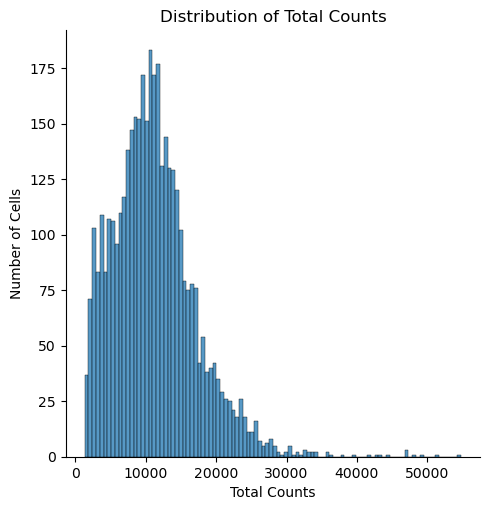

In [18]:
# 5. Visualize QC Metrics
# --------------------------
# Distribution of total counts
sns.displot(adata.obs["total_counts"], bins=100, kde=False)
plt.title("Distribution of Total Counts")
plt.xlabel("Total Counts")
plt.ylabel("Number of Cells")
plt.show()


1. Distribution of Total Counts
Plot Description:
The x-axis represents the total counts (UMI counts) per cell.
The y-axis represents the number of cells.
Interpretation:
Most cells have total counts in the range of ~10,000–30,000.
There are a few cells with very high total counts, likely outliers or doublets (two or more cells captured in the same droplet).
Cells with very low total counts may represent empty droplets or poor-quality cells.
Actionable Insights:
Set a lower threshold: Exclude cells with total counts below a certain threshold (e.g., <1,000) to remove low-quality cells.
Investigate outliers: Cells with unusually high counts may need to be flagged for further investigation.

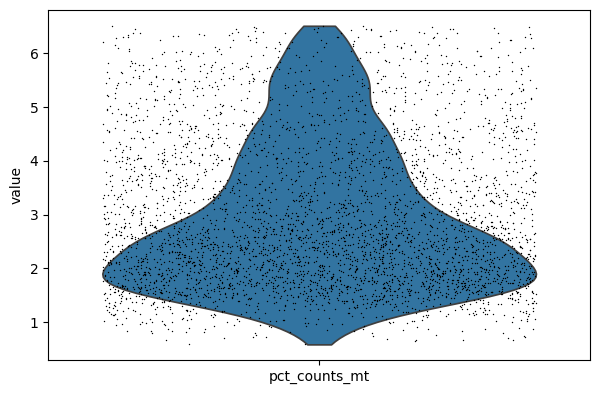

In [19]:
# Violin plot for mitochondrial percentage
sc.pl.violin(adata, "pct_counts_mt", jitter=0.4)


2. Violin Plot of Percentage of Mitochondrial Counts
Plot Description:
The x-axis represents the percentage of mitochondrial gene expression (pct_counts_mt).
The y-axis shows the density and spread of this metric across all cells.
Interpretation:
Most cells have a low percentage of mitochondrial gene expression (around 0–5%).
A few cells have a very high percentage of mitochondrial expression, which could indicate stressed or dying cells.
Actionable Insights:
Filter high mitochondrial content cells: Set a threshold for mitochondrial gene expression (e.g., <20%) and remove cells that exceed it.
High mitochondrial expression is often a marker of poor cell quality.

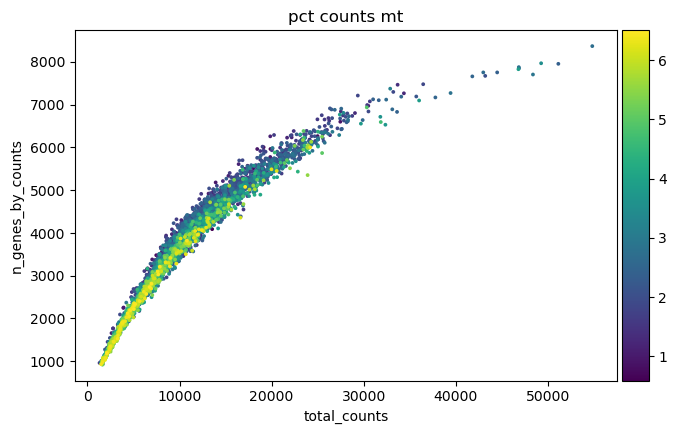

In [20]:

# Scatter plot: total counts vs. number of genes, colored by % mitochondrial counts
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

3. Scatter Plot of Total Counts vs. Mitochondrial Percentage
Plot Description:
The x-axis represents total counts (UMIs) per cell.
The y-axis represents the number of genes detected per cell.
Color represents the percentage of mitochondrial gene expression.
Interpretation:
A clear positive correlation between total counts and the number of genes detected is expected. This suggests the data is consistent.
Cells with high mitochondrial percentages (shown in brighter colors) tend to have lower total counts and fewer detected genes, supporting the idea that these are low-quality cells.
Actionable Insights:
Set thresholds for total counts and mitochondrial percentage:
Remove cells with low total counts and high mitochondrial content.
Double-check clusters of outliers:
Investigate cells with very high total counts or mitochondrial percentages to ensure they are not artifacts or doublets.

## Identify Outliers with MAD

Why Use MAD to Identify Outliers?
The MAD method is a robust statistical measure, resistant to the influence of extreme values, making it well-suited for identifying outliers in biological data.
Outliers often indicate low-quality or abnormal cells that can skew downstream analyses.


In [16]:
# 6. Identify Outliers with MAD
# --------------------------
def is_outlier(adata, metric: str, nmads: int):
    """
    Identify outliers in adata.obs for a given metric using a threshold of nmads.
    
    Parameters:
      - adata: AnnData object.
      - metric: The column in adata.obs to evaluate.
      - nmads: Number of median absolute deviations away from the median.
    
    Returns:
      - A boolean Series with True for outliers.
    """
    M = adata.obs[metric]
    median_val = np.median(M)
    mad_val = median_abs_deviation(M)
    # Outlier if below or above median ± (nmads * MAD)
    outlier = (M < median_val - nmads * mad_val) | (M > median_val + nmads * mad_val)
    return outlier

# Mark outliers based on:
# - log1p_total_counts, log1p_n_genes_by_counts, and pct_counts_in_top_20_genes using 5 MADs.
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)

print("Outlier counts (based on total counts, gene counts, and top 20 %):")
print(adata.obs["outlier"].value_counts())

# Additionally, mark cells as mitochondrial outliers:
#   - using 3 MADs on pct_counts_mt OR
#   - if the percentage of mitochondrial counts exceeds 8%
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 8)

print("Mitochondrial outlier counts:")
print(adata.obs["mt_outlier"].value_counts())

Outlier counts (based on total counts, gene counts, and top 20 %):
outlier
False    4704
True      288
Name: count, dtype: int64
Mitochondrial outlier counts:
mt_outlier
False    4295
True      697
Name: count, dtype: int64


How to Interpret These Results
General Outliers (adata.obs["outlier"]):
These cells deviate significantly in terms of total counts, number of genes detected, or dominance of the top 20 expressed genes.
High outliers could indicate doublets (two cells captured in one droplet), while low outliers may indicate poor-quality cells or empty droplets.
Mitochondrial Outliers (adata.obs["mt_outlier"]):
High mitochondrial content often indicates cell stress or apoptosis.
These cells are typically removed during QC to ensure the dataset contains only healthy cells.

## Filter out low quality cells 

Total number of cells before filtering: 4992
Number of cells after filtering low-quality cells: 4053


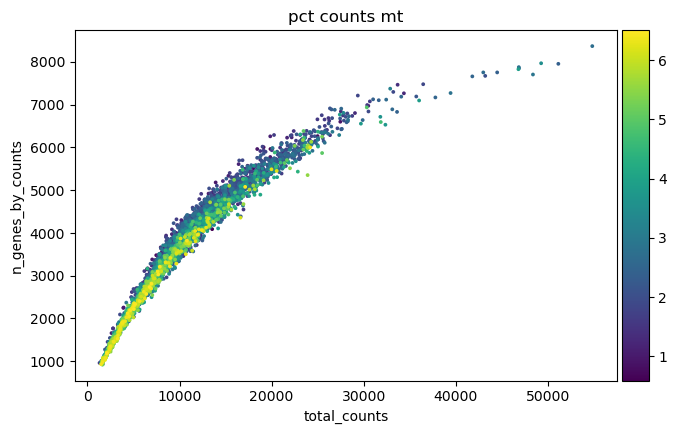

In [17]:
# --------------------------
# 7. Filter Out Low-Quality Cells
# --------------------------
print(f"Total number of cells before filtering: {adata.n_obs}")

# Retain only cells that are not flagged as outliers in either category.
adata = adata[(~adata.obs["outlier"]) & (~adata.obs["mt_outlier"])].copy()

print(f"Number of cells after filtering low-quality cells: {adata.n_obs}")

# Optional: visualize the relationship after filtering
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


nterpretation of the Output
Before and After Filtering:
Initial dataset: 4992 cells.
After filtering: 4053 cells.
This means 939 cells (18.8%) were removed due to low quality, either because they were general outliers or mitochondrial outliers.
Scatter Plot:
The relationship between total counts and number of genes detected:
The strong positive correlation remains, indicating consistency in the dataset.
Color (mitochondrial percentage):
Most cells have low mitochondrial gene expression (darker colors).
High mitochondrial outliers (bright yellow) have been removed.
No visible outliers: Filtering effectively removed anomalous cells, resulting in a cleaner dataset.

In [21]:
adata.write("filtered_data.h5ad")


In [22]:
adata.to_df().to_csv("filtered_gene_expression_matrix.csv")


In [23]:
# Save metadata seperately 
# Cell metadata
adata.obs.to_csv("filtered_cell_metadata.csv")

# Gene metadata
adata.var.to_csv("filtered_gene_metadata.csv")

